In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


-- 배경시식
- LSTM / RNN 등의 구조가 쌓이는 갯수는, PAST HISTORY (즉 몇개 데이터 가지고 다음값을 예측할지) 만큼 가로로 쌓인다.
- KERAS 에서 OUTPUT 은 HIDDEN NODES 층에서의 출력값이다.
- NN

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)


In [3]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
# history_size : 과거 information window의 크기 입니다 (몇 개의 과거 데이터를 학습할것인지)
# target_size : 예측해야하는 레이블 입니다. 얼마나 멀리있는 예측을 배워야 하는가이다.
# start_index : 어떤 index 부터 시작할지.
# end_index : 어떤 index 까지 사용할지
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    
    if end_index is None: # end index 를 지정을 안해주면
        end_index = len(dataset) - target_size # dataset 의 크기 - target size . 즉 최대한도로 모두 window 로 만들겠다는 의미입니다.

    for i in range(start_index, end_index): # start_index 에서 끝 인덱스까지
        indices = range(i-history_size, i) 
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1))) # reshape 을 해주어야한다. 맨 마지막은 batch size 가 될것!
        labels.append(dataset[i+target_size]) # labels 는 y target 이 되는 값으로서, target size 만큼 떨어져있어야 하므로
        
    return np.array(data), np.array(labels)

- 데이터의 처음 300,000개 행은 train dataset이고 나머지는 validation dataset입니다
- 2100일 분량의 train data에 해당합니다


In [5]:
TRAIN_SPLIT = 300000
# 재현성을 보장하기 위해 시드 설정.
tf.random.set_seed(13)

# 1 부 : Univariate 시계열 예측


단일 특성(온도)만 사용하여 모델을 학습하고 향후 해당 값을 예측하는 데 사용합니다

데이터 세트에서 온도만 추출합니다


In [6]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

C:\Users\goran\Anaconda3\envs\tensor\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


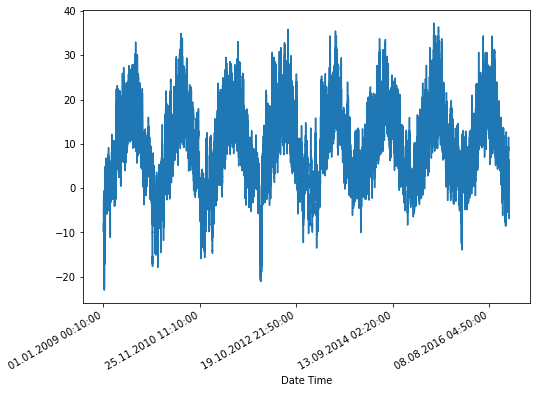

In [7]:
uni_data.plot(subplots=True) ;

In [8]:
uni_data = uni_data.values

- 신경망을 훈련하기 전 기능을 확장하는 것이 중요하다
-  표준화는 평균을 빼고 각 피처의 표준 편차로 나눔으로써 스케일링을 수행하는 일반적인 방법이다
- tf.keras.utils.normalize값은 [0,1]범위로 재조정 하는 방법을 사용할 수도 있다
- Note: 평균 및 표준 편차는 훈련 데이터만을 사용하여 계산해야합니다

In [9]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
# 데이터를 표준화합시다.
uni_data = (uni_data-uni_train_mean)/uni_train_std


In [10]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [11]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [12]:
def create_time_steps(length):
    return list(range(-length, 0))


In [13]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


<module 'matplotlib.pyplot' from 'C:\\Users\\goran\\Anaconda3\\envs\\tensor\\lib\\site-packages\\matplotlib\\pyplot.py'>

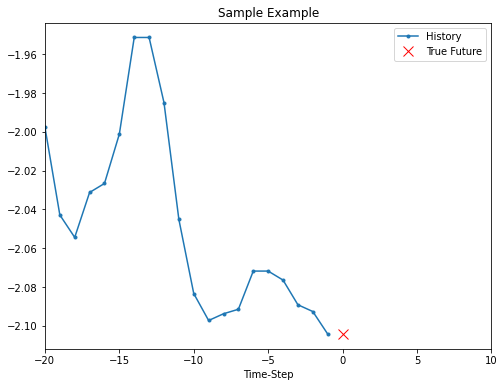

In [14]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')


In [15]:
def baseline(history):
  return np.mean(history)


<module 'matplotlib.pyplot' from 'C:\\Users\\goran\\Anaconda3\\envs\\tensor\\lib\\site-packages\\matplotlib\\pyplot.py'>

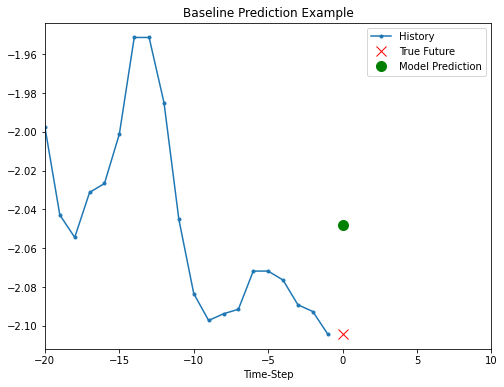

In [16]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')


In [17]:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
dataset = dataset.repeat(2)
list(dataset.as_numpy_iterator())

[1, 2, 3, 1, 2, 3]

In [18]:
# tf data set 으로 만들기( 선택사항 )

BATCH_SIZE = 256
BUFFER_SIZE = 10000

#tf.data.Dataset의 from_tensor_slices()는 주어진 텐서들 ((x_train_uni, y_train_uni))을 첫번째 차원(여기서는 sample 이겟죠) 따라 슬라이스합니다.
#모든 입력 텐서는 첫번째 차원과 같은 크기를 가져야합니다.
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
# tensorflow 에서는 data 를 tf.data.Dataset 형태로 받으면 많은것을 할 수 있다. ( 변형이라던지/...)
# from_tensor_slices 클래스 메서드를 사용하면 리스트, 넘파이, 텐서플로 자료형에서 데이터셋을 만들 수 있다!


train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# cache()는 데이터셋을 캐시, 즉 메모리 또는 파일에 보관합니다. 따라서 두번째 이터레이션부터는 캐시된 데이터를 사용합니다.
# 해당 데이터셋이 반복되는 상황에서 캐싱한다는 뜻입니다. 캐싱이라는 것은, 데이터를 RAM과 같이 빨리 사용할수 있는 구간에 저장해두고, 다음에 사용할 때 빠르게 사용하기 위한 방식입니다.
# 이미지 데이터를 로딩한 이후, 한번 사용했다고 메모리에서 지우고 다시 불러오기를 반복한다면 성능저하가 심하죠.

# shuffle()는 데이터셋을 임의로 섞어줍니다. BUFFER_SIZE개로 이루어진 버퍼로부터 임의로 샘플을 뽑고, 뽑은 샘플은 다른 샘플로 대체합니다. 
# 완벽한 셔플을 위해서 전체 데이터셋의 크기에 비해 크거나 같은 버퍼 크기가 요구됩니다.

# batch()는 데이터셋의 항목들을 하나의 배치로 묶어줍니다.
# repeat라는 함수는 데이터셋을 읽다가 마지막에 도달했을 경우, 다시 처음부터 조회하는 함수입니다.

In [19]:
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni)) # 주어진 tesnsor 를 data 로  

val_univariate = val_univariate.batch(BATCH_SIZE).repeat() 
# 이떄에는 Batchsize 만큼 묶어줍니다.
# validation 이라서 학습을 하지 않기떄문에, 순서는 굳이 섞을필요가 없습니다.

In [20]:
simple_lstm_model = tf.keras.models.Sequential([
      # x_train_uni.shape = (299980, 20, 1)
    # input shape 는 sample 을 제외한 형태로 들어가야해요!
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[1:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')


In [22]:
# 아래와 같이 그냥 x_train 을 나눈것을 사용할 수도 있다.

In [23]:
print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)

(299980, 20, 1)
(299980,)
(120531, 20, 1)
(120531,)


In [24]:
simple_lstm_model.fit(x_train_uni,y_train_uni, epochs=2,
                      validation_data=(x_val_uni,y_val_uni),batch_size = 1024 ) # 

Epoch 1/2
293/293 [==============================] - 9s 32ms/step - loss: 0.2618 - val_loss: 0.0648
Epoch 2/2
293/293 [==============================] - 8s 27ms/step - loss: 0.0502 - val_loss: 0.0340


In [25]:
EVALUATION_INTERVAL = 200 
# 200번만 하겠다.
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL, # 데이터셋이 남아있겟지만 200번만
                      validation_data=val_univariate,
                      validation_steps=50 # val 도 똑같은 이유
                     )
# 주의해야할 점은 위의 per_epoch/ step 등의 고급설정은 tf.dataset 일 때에만 가능하다. 주의!

Epoch 1/10
200/200 [==============================] - 5s 25ms/step - loss: 0.0337 - val_loss: 0.0205
Epoch 2/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0283 - val_loss: 0.0184
Epoch 3/10
200/200 [==============================] - 4s 18ms/step - loss: 0.0248 - val_loss: 0.0178
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0244 - val_loss: 0.0168
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0193 - val_loss: 0.0161
Epoch 6/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0214 - val_loss: 0.0154
Epoch 7/10
200/200 [==============================] - 4s 18ms/step - loss: 0.0203 - val_loss: 0.0152
Epoch 8/10
200/200 [==============================] - 4s 18ms/step - loss: 0.0200 - val_loss: 0.0146
Epoch 9/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0198 - val_loss: 0.0148
Epoch 10/10
200/200 [==============================] - 4s 18ms/step - loss: 0.0185 - val_lo

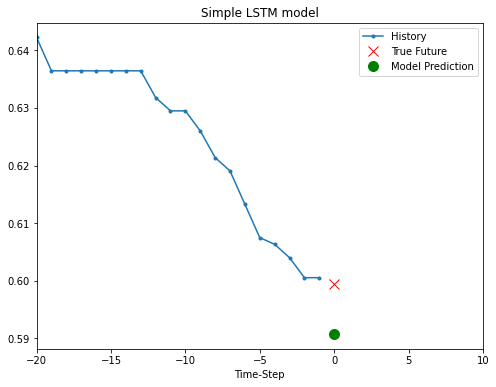

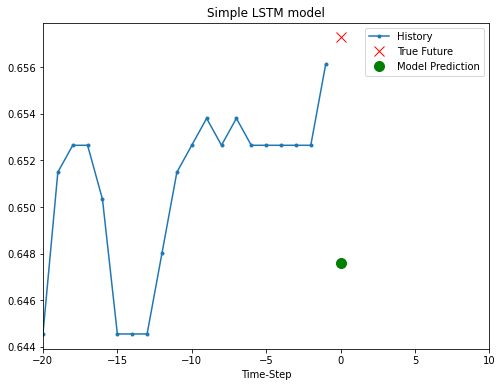

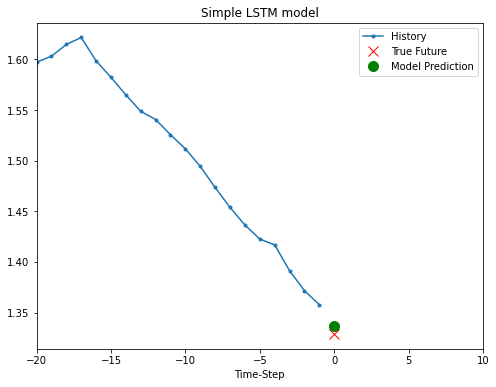

In [25]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

# 2부 Multivariate 시계열 예측

- 원본 데이터 세트에는 14개의 특성이 있습니다. 간단하게하기 위해 14개 중 3개만 고려합니다.
- 사용되는 특성은 대기 온도, 대기압, 공기 밀도입니다
- 더 많은 특성을 사용하려면 해당 특성 이름을 목록에 추가하세요.


In [36]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
# 3개만 고려하겠다.
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


C:\Users\goran\Anaconda3\envs\tensor\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


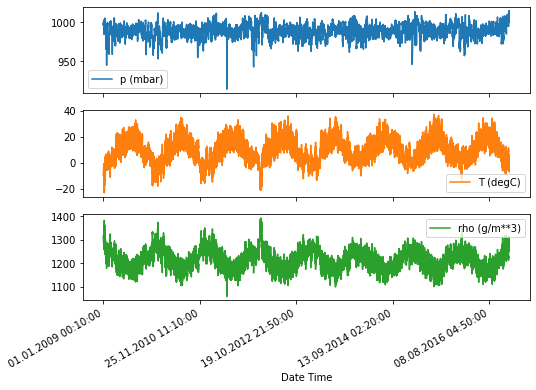

In [37]:
features.plot(subplots=True)
plt.show()

In [38]:
# 표준화를 해 주어야한다.
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std
print(dataset)

[[ 0.95547359 -1.99766294  2.2350791 ]
 [ 0.96154485 -2.04281897  2.28524007]
 [ 0.95668784 -2.05439744  2.29600633]
 ...
 [ 1.35617678 -1.43494935  1.76136375]
 [ 1.35496252 -1.55883897  1.88786728]
 [ 1.35617678 -1.62715193  1.95686921]]


## Single step 예측

In [51]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step) # step 이 추가되었다. 즉 몇번씩 건너뛰면서 예측해야되는 경우가 해단된다.
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size]) # labels 는 y target 이 되는값.
        else:
            labels.append(target[i:i + target_size]) # i + target_size 만큼 labelss 를 append 하겠다는 의미
    return np.array(data), np.array(labels)
# 이 경우는 single step 이 들어간 경우이다.
# t

- 네트워크에 지난 5일 동안의 데이터, 즉 매 시간마다 샘플링되는 720개의 관측치가 표시됩니다
- 60분 내에 급격한 변화가 예상되지 않으므로 샘플링은 1시간마다 수행됩니다
- 120개의 관측치는 지난 5일의 이력을 나타냅니다
- Single step model의 경우 데이터 포인트의 레이블은 12 시간 뒤의 온도입니다. (12시간 뒤의 온도 예측)
- 이를위한 레이블을 만들기 위해 72(12*6)관찰 후 온도가 사용됩니다


In [ ]:
past_history = 720 # 720개의 관측치를 토대로 예측할거야!
future_target = 72 # 예측하고싶은건 12시간 뒤야! (그러면 72 뒤의 데이터를 예측해야함.)
STEP = 6 
# 하나의 data 간격이 10분이다. 60분 동안은 큰 변화가 없어보이므로, 샘플링은 6개 간격으로 하자.!
# 이렇게 하면, STEP 을 1로 두고 하면, 같은 시간대비 데이터가 길어지고, SAMPLE 수가 작아져서 효율적인 학습이 안된다.

x_train_single, y_train_single = multivariate_data(dataset, # Whole train data set 
                                                   dataset[:, 1], # tearget 이 되는 데이터셋
                                                   0, # 언제부터 시작? (거의다 0이죠뭐.. 0번쨰부터 해야되니까)
                                                   TRAIN_SPLIT, # 끝나는 지점인데 30000개까지가 train set 이라고 했으니까 30000!
                                                   past_history,# 몇개를 토대로 예측을 혀형성할지
                                                   future_target, # 몇스텝 뒤의 예측값을 형성하고픈지
                                                   STEP, # step 을 건너뛰면서 예측데이터를 형성할건지.
                                                   single_step=True # 이는 single step, 즉 y value 를 하나만 예측하겠다는 소리이다.
                                                  )
x_val_single, y_val_single = multivariate_data(dataset, 
                                               dataset[:, 1],
                                               TRAIN_SPLIT, # 이 경우는 val 데이터이기떄문에 시작점이 위에서 end 지점이다.
                                               None, # NOne 이면 끝까지 다 쓰겟다는거!
                                               past_history, 
                                               future_target,
                                               STEP,
                                               single_step=True)


In [54]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [55]:
# tf.dataset 형태로 바꾸어주어야 합니다.
# 솔직히 이거는 선택사항인듯. 그냥 쓰는경우도 적지않다.
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()


In [56]:

single_step_model = tf.keras.models.Sequential() # sequential 을 쌓는다.
single_step_model.add(tf.keras.layers.LSTM(32, # 여기서의 output 은 hidden note 에서 출력되는 값의 dim 을 말한다. 
                                           input_shape=x_train_single.shape[-2:]))
# output 이 계속 이어지면서 나중에는 출력시에도 이용된다. 
single_step_model.add(tf.keras.layers.Dense(1))
# 위 32개의 hidden node 의 출력을 받아 NN 층에서 합쳐진다.
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')


In [57]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50) # VALIDATION 의 경우에도 너무 오래걸릴거같아서 STEP 제한했다...
# BATCH 는 이미 위에서 모두 정해서 여기에서는 BATCH 가 없는 모습이다.


Epoch 1/10
200/200 [==============================] - 17s 83ms/step - loss: 0.3360 - val_loss: 0.2671
Epoch 2/10
200/200 [==============================] - 20s 102ms/step - loss: 0.2653 - val_loss: 0.2420
Epoch 3/10
200/200 [==============================] - 25s 123ms/step - loss: 0.2596 - val_loss: 0.2378
Epoch 4/10
200/200 [==============================] - 30s 149ms/step - loss: 0.2605 - val_loss: 0.2393
Epoch 5/10
200/200 [==============================] - 35s 176ms/step - loss: 0.2280 - val_loss: 0.2425
Epoch 6/10
200/200 [==============================] - 39s 193ms/step - loss: 0.2404 - val_loss: 0.2526
Epoch 7/10
200/200 [==============================] - 39s 197ms/step - loss: 0.2411 - val_loss: 0.2492
Epoch 8/10
200/200 [==============================] - 40s 199ms/step - loss: 0.2426 - val_loss: 0.2428
Epoch 9/10
200/200 [==============================] - 39s 193ms/step - loss: 0.2462 - val_loss: 0.2424
Epoch 10/10
200/200 [==============================] - 36s 179ms/step - lo

In [58]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()


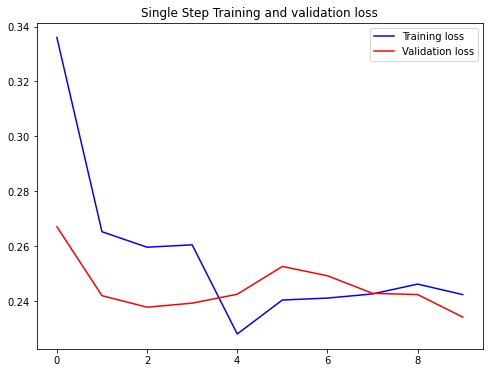

In [59]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')


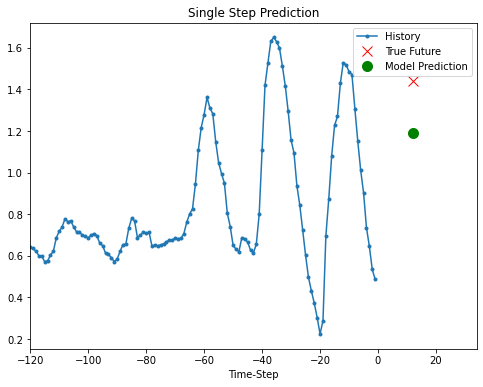

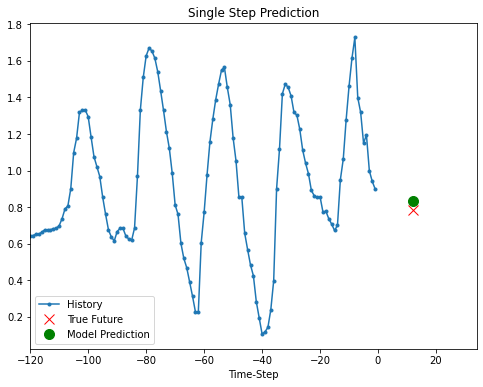

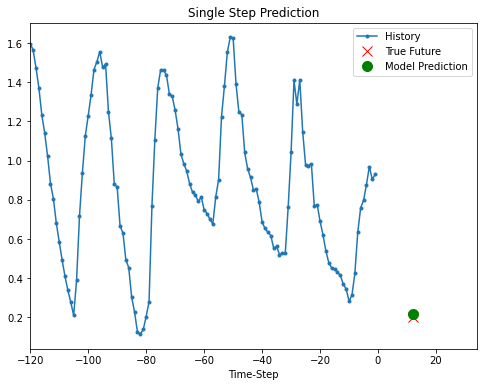

In [60]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()


## Multi step model


모델은 과거 히스토리가 주어지면 미래의 값 범위를 예측하는 법을 배워야합니다

하나의 미래 포인트만 예측하는 Single step model과 달리 Multi step model은 미래의 시퀀스를 예측합니다

Multi step model의 훈련 데이터는 다시 한 시간마다 샘플링 된 지난 5일 동안의 기록으로 구성됩니다

12시간 동안의 온도를 예측하는 방법을 학습해야합니다

10분마다 관측이 수행되므로 결과는 72(1x6x12)개의 예측입니다

데이터 세트를 적절히 다시 준비해야합니다.



In [61]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)


In [62]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [63]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [64]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()


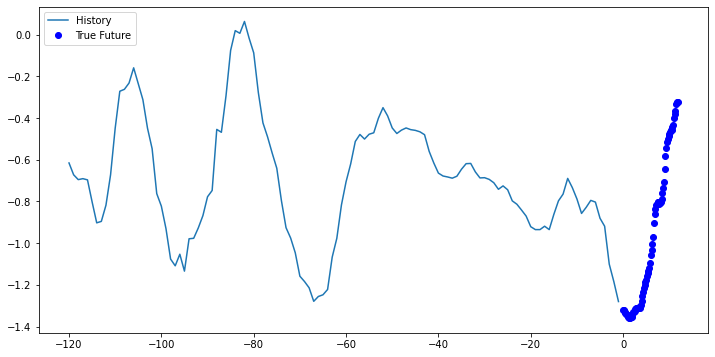

In [65]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))


이전 작업보다 조금 더 복잡하기 때문에 모델을 두 개의 LSTM 계층으로 구성합니다
마지막으로 72개의 예측이 이루어지므로, Dense layer는 72개의 예측을 출력합니다


In [66]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, # 제일 아래층
                                          return_sequences=True, 
                                          input_shape=x_train_multi.shape[-2:]))
# LSTM 에서는 return sequence 를 true로 해 주어야 서로 쌓일 수 있다.
# 왜냐하면 LSTM레이어의 Params를 계산하는 방법이 일반 Dense레이어와 다르다고 하였는데, 이전의 기록들이 다음 레이어로 들어가기 때문에 LSTM레이어끼리 엮기 위해서는 return_sequence를 사용하여야 합니다
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
# 이떄에는 return_sequences=True 가 없습니다. 왜냐하면 어짜피 우리가 dense 에서 쓸것은 hidden 의 결과이기떄문에, 이것만 16dim 으로 받게되는것이다.
# 16개의 OUTPUT 이 뒤에서 DENSE 로 합쳐준다.
multi_step_model.add(tf.keras.layers.Dense(72)) 
# 우리는 72개의 값을 출력하므로, 마지막 DENSE 층에서 출력은 72 이다.

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [67]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)


(256, 72)


In [68]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 65s 325ms/step - loss: 0.5146 - val_loss: 0.2902
Epoch 2/10
200/200 [==============================] - 69s 343ms/step - loss: 0.3281 - val_loss: 0.2618
Epoch 3/10
200/200 [==============================] - 79s 394ms/step - loss: 0.2898 - val_loss: 0.2375
Epoch 4/10
200/200 [==============================] - 86s 430ms/step - loss: 0.2348 - val_loss: 0.2003
Epoch 5/10
200/200 [==============================] - 98s 492ms/step - loss: 0.1986 - val_loss: 0.2051
Epoch 6/10
200/200 [==============================] - 112s 560ms/step - loss: 0.2085 - val_loss: 0.2141
Epoch 7/10
200/200 [==============================] - 105s 526ms/step - loss: 0.2004 - val_loss: 0.2071
Epoch 8/10
200/200 [==============================] - 107s 536ms/step - loss: 0.1962 - val_loss: 0.1921
Epoch 9/10
200/200 [==============================] - 113s 564ms/step - loss: 0.2006 - val_loss: 0.1930
Epoch 10/10
200/200 [==============================] - 113s 563ms/ste

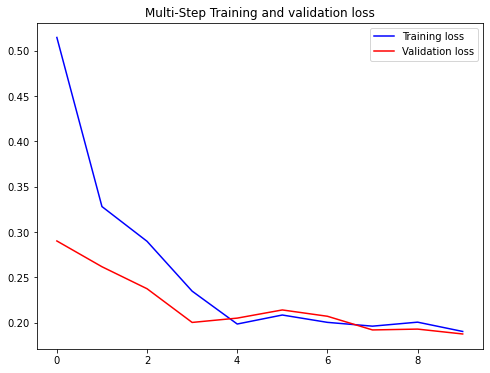

In [69]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')
# 훈련은 어느정도 잘 된거같네요

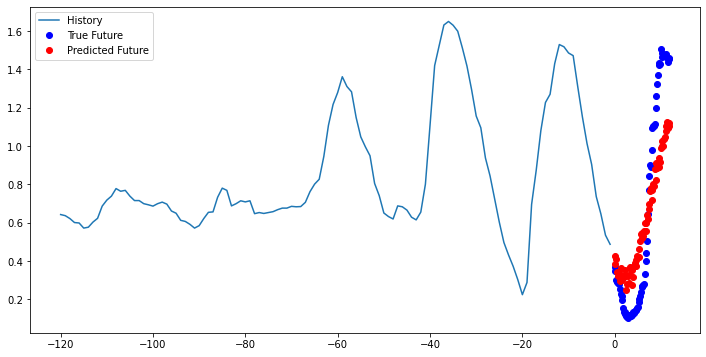

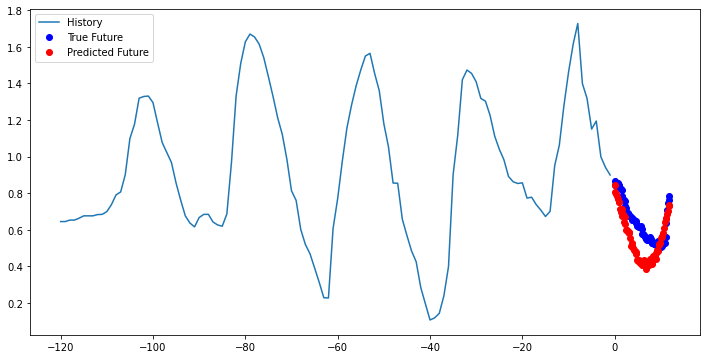

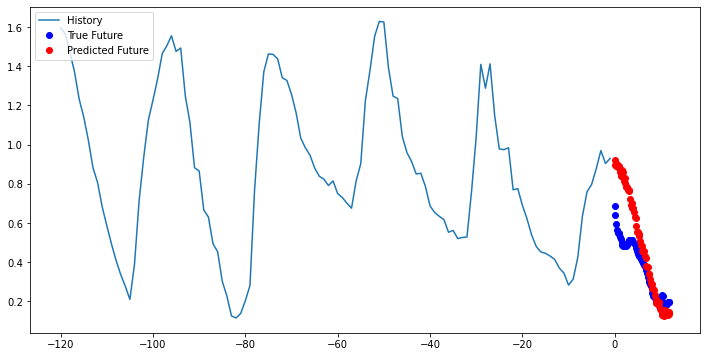

In [70]:
# 모델 예측도.. 뭐 나름? 한거같아요
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [ ]:
# 아래와 같이 GRU 를 대신 쓸 수도 있다.

In [79]:
import tensorflow as tf
from tensorflow import keras
model2 = keras.models.Sequential()
model2.add(keras.layers.GRU(50, return_sequences=True, input_shape=x_train_multi.shape[1:]))
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.GRU(100, return_sequences=False))
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Dense(1, activation = "linear"))

In [ ]:
# stateful lstm 
# 학습 모델은 LSTM(long short-term memory) 네트워크를 사용했다. LSTM 레이어에서 stateful=True를 설정해 이전 배치 작업에서 학습된 상태가 다음 배치 작업에도 영향을 줄 수 있게 했다.
# 상태유지 재발(Stateful recurrent) 모델은 샘플의 한 배치를 처리한 후 얻은 내부 상태(메모리)를 다음 배치 샘플의 초기값으로 다시 사용하는 모델입니다. 이렇게 하면 계산상의 복잡성을 줄이면서도 더 긴 시퀀스를 처리할 수 있습니다
import tensorflow as tf
from tensorflow import keras
model2 = keras.models.Sequential()
model2.add(keras.layers.GRU(50, return_sequences=True, input_shape=x_train_multi.shape[1:],stateful=True))
# return seq 가 true 면 time seq 값도 같이 나오기떄문에, 그 뒤의 nn 층에서 수합하기가 어렵다.
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.GRU(100, return_sequences=False,stateful=True)) # 마지막층에서는 return seq 를 사용하지 않는다.
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Dense(1, activation = "linear"))

# 다른 예제

In [2]:
# 0. 사용할 패키지 불러오기
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0]) # i ~ i+look_back 만큼의 데이터를 append
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 40 # 40개 데이터

In [76]:
# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

In [61]:
# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

In [62]:
# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

In [53]:
# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

In [55]:
x_train

array([[1.        , 0.99901336, 0.99605735, ..., 0.15772645, 0.13551569,
        0.11474338],
       [0.99901336, 0.99605735, 0.99114363, ..., 0.13551569, 0.11474338,
        0.0954915 ],
       [0.99605735, 0.99114363, 0.98429158, ..., 0.11474338, 0.0954915 ,
        0.07783604],
       ...,
       [0.04758647, 0.06184666, 0.07783604, ..., 0.96488824, 0.97552826,
        0.98429158],
       [0.06184666, 0.07783604, 0.0954915 , ..., 0.97552826, 0.98429158,
        0.99114363],
       [0.07783604, 0.0954915 , 0.11474338, ..., 0.98429158, 0.99114363,
        0.99605735]])

In [68]:
# 2. 모델 구성하기
model = Sequential()
model.add(Dense(32,input_dim=40,activation="relu"))
model.add(Dropout(0.3))
for i in range(2):
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.3))
model.add(Dense(1))

In [69]:
# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adagrad')

In [70]:
# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/200
24/24 [==============================] - 0s 12ms/step - loss: 0.5609 - val_loss: 0.3184
Epoch 2/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4493 - val_loss: 0.2725
Epoch 3/200
24/24 [==============================] - 0s 4ms/step - loss: 0.3952 - val_loss: 0.2418
Epoch 4/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3818 - val_loss: 0.2181
Epoch 5/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3390 - val_loss: 0.1985
Epoch 6/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3238 - val_loss: 0.1837
Epoch 7/200
24/24 [==============================] - 0s 3ms/step - loss: 0.2923 - val_loss: 0.1698
Epoch 8/200
24/24 [==============================] - 0s 3ms/step - loss: 0.2489 - val_loss: 0.1541
Epoch 9/200
24/24 [==============================] - 0s 3ms/step - loss: 0.2520 - val_loss: 0.1405
Epoch 10/200
24/24 [==============================] - 0s 3ms/step - loss: 0.2574 - val_loss: 0.1347
Epoch 11

24/24 [==============================] - 0s 3ms/step - loss: 0.0745 - val_loss: 0.0225
Epoch 84/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0736 - val_loss: 0.0223
Epoch 85/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0693 - val_loss: 0.0217
Epoch 86/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0770 - val_loss: 0.0210
Epoch 87/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0721 - val_loss: 0.0212
Epoch 88/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0750 - val_loss: 0.0216
Epoch 89/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0703 - val_loss: 0.0220
Epoch 90/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0706 - val_loss: 0.0225
Epoch 91/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0711 - val_loss: 0.0220
Epoch 92/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0682 - val_loss: 0.0216
Epoch 93/200


24/24 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0142
Epoch 165/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0140
Epoch 166/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0510 - val_loss: 0.0139
Epoch 167/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0544 - val_loss: 0.0142
Epoch 168/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0479 - val_loss: 0.0144
Epoch 169/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0550 - val_loss: 0.0149
Epoch 170/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0152
Epoch 171/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0552 - val_loss: 0.0151
Epoch 172/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0475 - val_loss: 0.0148
Epoch 173/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0531 - val_loss: 0.0154
Epoc

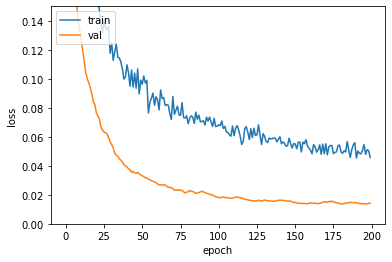

In [71]:
# 5. 학습과정 살펴보기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [72]:
          
# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: ', testScore)

Train Score:  0.014517676085233688
Validataion Score:  0.014218089170753956
Test Score:  0.014218089170753956


In [73]:
# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0, None]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(xhat, batch_size=32)
    predictions[i] = prediction
    xhat = np.hstack([xhat[:,1:],prediction])

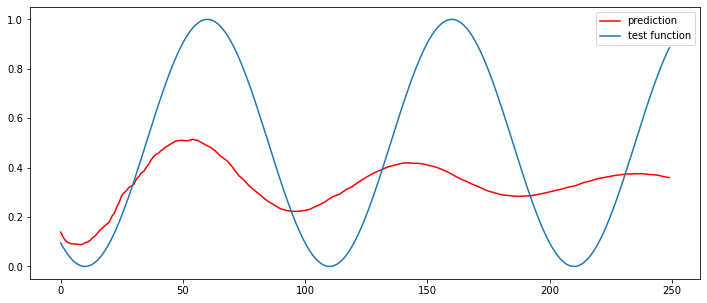

In [74]:
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()